In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import json
import importlib
import torch
from collections import OrderedDict
import cv2
import numpy as np
import copy

sys.path.append('../')
sys.path.append('../test')



In [2]:
from nnet.py_factory import NetworkFactory
from config import system_configs
from utils import crop_image, normalize_
from external.nms import soft_nms, soft_nms_merge
from coco import apply_detection

In [3]:
cfg_file = 'CenterNet-52-wideeyes'
configs = json.load(open('../config/' + cfg_file + '.json'))
configs["system"]["snapshot_name"] = cfg_file
system_configs.update_config(configs["system"])

system_configs.snapshot_name

'CenterNet-52-wideeyes'

In [4]:
def kp_decode(model, images, K, ae_threshold=0.5, kernel=3):
    with torch.no_grad():
        xs = [x.cuda(non_blocking=True) for x in images]
        detections, center = model(xs[0].unsqueeze(0), ae_threshold=ae_threshold, K=K, kernel=kernel)
    detections = detections.data.cpu().numpy()
    center = center.data.cpu().numpy()
    return detections, center

In [5]:
configs

{'system': {'dataset': 'WideEyes',
  'batch_size': 13,
  'sampling_function': 'kp_detection',
  'train_split': 'train',
  'val_split': 'minival',
  'learning_rate': 0.0001,
  'decay_rate': 10,
  'val_iter': 500,
  'opt_algo': 'adam',
  'prefetch_size': 6,
  'max_iter': 800000,
  'stepsize': 450000,
  'snapshot': 10000,
  'chunk_sizes': [13],
  'data_dir': '/media/nas',
  'pretrain': 'cache/nnet/CenterNet-52-wideeyes/CenterNet-52-wideeyes_480000.pkl',
  'snapshot_name': 'CenterNet-52-wideeyes'},
 'db': {'rand_scale_min': 0.6,
  'rand_scale_max': 1.4,
  'rand_scale_step': 0.1,
  'rand_scales': None,
  'rand_crop': True,
  'rand_color': True,
  'border': 128,
  'gaussian_bump': True,
  'input_size': [511, 511],
  'output_sizes': [[128, 128]],
  'test_scales': [1],
  'top_k': 70,
  'categories': 53,
  'kp_categories': 1,
  'ae_threshold': 0.5,
  'nms_threshold': 0.5,
  'max_per_image': 100}}

In [6]:
module_file = "models.{}".format(system_configs.snapshot_name)
module_file = '-'.join(module_file.split('-')[:2])
print(module_file)
nnet_module = importlib.import_module(module_file)

models.CenterNet-52


In [7]:
class FakeDB:
    def __init__(self, config):
        for k, v in config.items():
            self.__setattr__(k, v)

In [8]:
configs['db'].update({'nms_kernel': 3})
db = FakeDB({'configs': configs['db']})

In [9]:
db.configs

{'rand_scale_min': 0.6,
 'rand_scale_max': 1.4,
 'rand_scale_step': 0.1,
 'rand_scales': None,
 'rand_crop': True,
 'rand_color': True,
 'border': 128,
 'gaussian_bump': True,
 'input_size': [511, 511],
 'output_sizes': [[128, 128]],
 'test_scales': [1],
 'top_k': 70,
 'categories': 53,
 'kp_categories': 1,
 'ae_threshold': 0.5,
 'nms_threshold': 0.5,
 'max_per_image': 100,
 'nms_kernel': 3}

In [10]:
model = nnet_module.model(db)

In [11]:
snapshot = torch.load('/media/db-office-secondary/models/production/centernet_v100/CenterNet-52-wideeyes_800000_with_thresholds.pkl')



In [12]:
opt_thresholds = snapshot['optimal_thresholds']
class_labels = snapshot['class_labels']

In [13]:
weights = OrderedDict()
for k, v in snapshot['state_dict'].items():
    weights[k.replace('module.', '')] = v

In [14]:
list(model.state_dict().keys())[:2]

['pre.0.conv.weight', 'pre.0.bn.weight']

In [15]:
model.load_state_dict(weights)
model = model.cuda()

In [16]:
model.eval()

model(
  (pre): Sequential(
    (0): convolution(
      (conv): Conv2d(3, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (1): residual(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace)
    )
  )
  (kps): ModuleList(
    (0): kp_module(
      (up1): Sequenti

In [17]:
image_filename = '/tmp/15652895807184.jpg'
image = cv2.imread(image_filename)

height, width = image.shape[:2]

if max(height, width) > 512:
    ori_scale = max(height, width) / 512.
    image = cv2.resize(image, (int(width/ori_scale), int(height/ori_scale)), cv2.INTER_LINEAR)
else:
    ori_scale = 1

In [18]:
_mean = np.array([0.40789654, 0.44719302, 0.47026115], dtype=np.float32)
_std  = np.array([0.28863828, 0.27408164, 0.27809835], dtype=np.float32)

In [20]:
scales = [1]
scales = [0.6, 1, 1.2, 1.5, 1.8]
merge_bbox = False if len(scales) == 1 else True
top_k = 100 if len(scales) == 1 else 70
# class_labels = sn

nms_algorithm = {"nms": 0,
                 "linear_soft_nms": 1,
                 "exp_soft_nms": 2
                }["exp_soft_nms"]


detections = apply_detection(image, model, scales=scales, decode_func=kp_decode,
                             categories=len(class_labels), top_k=top_k,
                             merge_bbox=False, nms_threshold=db.configs['nms_threshold'],
                             nms_algorithm=nms_algorithm,  weight_exp=10,
                             avg=_mean, std=_std)

> /home/longyu/projects/third_parties/CenterNet/test/coco.py(110)apply_detection()
-> center = center.reshape(2, -1, 4)
(Pdb) center.shape
(1, 70, 4)
(Pdb) n
> /home/longyu/projects/third_parties/CenterNet/test/coco.py(111)apply_detection()
-> dets[1, :, [0, 2]] = out_width - dets[1, :, [2, 0]]
(Pdb) c
> /home/longyu/projects/third_parties/CenterNet/test/coco.py(109)apply_detection()
-> import pdb; pdb.set_trace()
(Pdb) c
> /home/longyu/projects/third_parties/CenterNet/test/coco.py(110)apply_detection()
-> center = center.reshape(2, -1, 4)
(Pdb) c
> /home/longyu/projects/third_parties/CenterNet/test/coco.py(109)apply_detection()
-> import pdb; pdb.set_trace()
(Pdb) c
> /home/longyu/projects/third_parties/CenterNet/test/coco.py(110)apply_detection()
-> center = center.reshape(2, -1, 4)
(Pdb) c


In [21]:
for k, v in detections.items():
    detections[k] = v[:4] * ori_scale

In [22]:
detections

{1: array([[2.0932060e+02, 3.1962888e+02, 3.8498877e+02, 5.4784186e+02,
         1.9418588e-01],
        [4.7492084e+02, 4.4392612e+02, 6.3028351e+02, 5.4784894e+02,
         1.7897591e-01],
        [4.7371744e+02, 4.3601044e+02, 6.3109619e+02, 5.4746521e+02,
         3.0156061e-02],
        [2.0984608e+02, 3.1943042e+02, 3.8454037e+02, 5.4595953e+02,
         2.4961969e-02]], dtype=float32),
 2: array([], shape=(0, 5), dtype=float32),
 3: array([[4.2230341e+02, 1.4055862e+02, 6.7851569e+02, 4.5630563e+02,
         6.3276422e-01],
        [1.5331393e+02, 1.4120300e+02, 4.3726465e+02, 4.7430228e+02,
         4.8952445e-01],
        [2.0650307e+02, 1.4095639e+02, 4.3803748e+02, 4.7179459e+02,
         1.0959179e-01],
        [4.2258997e+02, 1.4110318e+02, 6.8129059e+02, 4.6136258e+02,
         8.6783446e-02]], dtype=float32),
 4: array([[2.8114282e+02, 2.0505942e+02, 3.6091281e+02, 3.3170563e+02,
         2.7060694e-01],
        [2.8005252e+02, 1.6166893e+02, 3.5770984e+02, 3.2964252e+02

blazer 422 140 678 456
blazer 153 141 437 474
t-shirt 281 205 360 331
bag 196 335 267 425
bag 180 320 282 462
coat 412 141 681 461
coat 153 141 437 474
purse 612 383 659 473
purse 196 335 267 425
purse 180 320 282 462
blouse 276 202 360 332
jacket 153 141 437 474
jacket 422 141 681 461
pants 474 443 634 547
pants 209 319 384 547
pants 470 379 634 547
sweater 422 141 681 461
shirt 157 143 440 470
shirt 421 142 678 452
jeans 204 320 385 546
jeans 473 436 631 547
jeans 213 433 383 548
top 283 209 360 332
top 153 141 425 397
cardigan 153 141 437 474
cardigan 412 141 681 461
sunglasses 282 76 358 112
sunglasses 534 46 606 87
necklace 283 148 345 232
necklace 523 155 576 187
suit 422 140 684 548
wallet 611 381 658 473


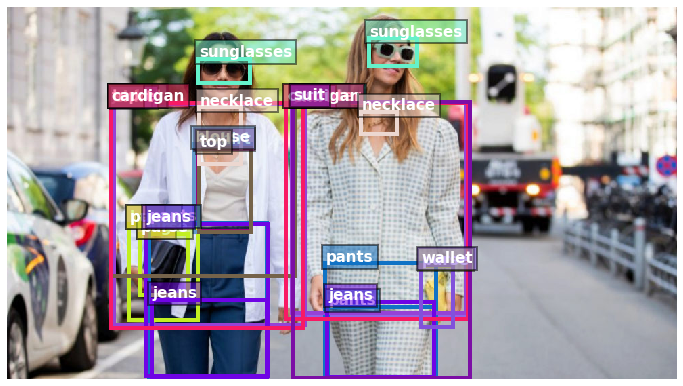

In [23]:
image      = cv2.imread(image_filename)
im         = image[:, :, (2, 1, 0)]
fig, ax    = plt.subplots(figsize=(12, 12))
fig        = ax.imshow(im, aspect='equal')
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
#bboxes = {}      

colours = np.random.rand(80,3)

# for j in range(1, configs['db']['categories'] + 1):
for class_name, j in class_labels.items():
    if j == 0 or detections[j].size == 0:
        continue
    keep_inds = (detections[j][:, -1] >= opt_thresholds[class_name])
    # cat_name  = db.class_name(j)
    for bbox in detections[j][keep_inds]:
        bbox  = bbox[0:4].astype(np.int32)
        xmin     = bbox[0]
        ymin     = bbox[1]
        xmax     = bbox[2]
        ymax     = bbox[3]
        print(class_name, xmin, ymin, xmax, ymax)
        ax.add_patch(plt.Rectangle((xmin, ymin),xmax - xmin, ymax - ymin, fill=False, edgecolor= colours[j-1],
                     linewidth=4.0))
        ax.text(xmin+1, ymin-3, '{:s}'.format(class_name), bbox=dict(facecolor= colours[j-1], ec='black', lw=2,alpha=0.5),
                fontsize=15, color='white', weight='bold')


In [68]:
for k, v in top_bboxes.items():
    if v.shape[0]:
        print(k, v[:, -1])

3 [0.1390815  0.11598903 0.02685295 0.00373336]
4 [0.08964509 0.02343999 0.00337179]
5 [0.27888343 0.11323521 0.09977385 0.02867935 0.02717333 0.01206546]
7 [0.13561873 0.0980268  0.02616478]
9 [0.33085513 0.142886   0.07942381 0.03705384]
11 [0.0738292]
12 [0.17515643 0.09962263 0.03491435 0.00491093]
15 [0.3365327  0.28373075]
17 [0.29571113 0.22516553 0.08206508 0.05385945 0.03061548 0.01355486
 0.00404141 0.00241753 0.00068607 0.00198552 0.0006479  0.00310069]
18 [0.2024126  0.0988993  0.02847687]
19 [0.08115971]
22 [0.28951028 0.11534358 0.03948982 0.02047651 0.00391291 0.00086275]
23 [0.12845777]
24 [0.05252567]
26 [0.51722616 0.46578732]
27 [0.08255421]
29 [0.05200839]
32 [0.29168722 0.21729748 0.13089512 0.08772357 0.01985711]
40 [0.07265972]
51 [0.07958645]


In [23]:
detections[:, 4].max()

0.22592396

In [52]:
j ==0 or top_bboxes[j].size == 0

True

In [32]:
opt_thresholds

{'tights': 1,
 'shorts': 2,
 'blazer': 3,
 't-shirt': 4,
 'bag': 5,
 'shoes': 6,
 'coat': 7,
 'skirt': 8,
 'purse': 9,
 'boots': 10,
 'blouse': 11,
 'jacket': 12,
 'bra': 13,
 'dress': 14,
 'pants': 15,
 'sweater': 16,
 'shirt': 17,
 'jeans': 18,
 'leggings': 19,
 'scarf': 20,
 'hat': 21,
 'top': 22,
 'cardigan': 23,
 'accessories': 24,
 'vest': 25,
 'sunglasses': 26,
 'belt': 27,
 'socks': 28,
 'glasses': 29,
 'intimate': 30,
 'stockings': 31,
 'necklace': 32,
 'cape': 33,
 'jumpsuit': 34,
 'sweatshirt': 35,
 'suit': 36,
 'bracelet': 37,
 'heels': 38,
 'wedges': 39,
 'ring': 40,
 'flats': 41,
 'tie': 42,
 'romper': 43,
 'sandals': 44,
 'earrings': 45,
 'gloves': 46,
 'sneakers': 47,
 'clogs': 48,
 'watch': 49,
 'pumps': 50,
 'wallet': 51,
 'bodysuit': 52,
 'loafers': 53,
 '__background__': 0}

In [69]:
nms_algorithm

NameError: name 'nms_algorithm' is not defined